## Assignment # 02

### Step 1: Import Libraries

In [1]:
# Import the important libraries
import yfinance as yf                 # for yahoo finance data
import pandas as pd                  # for tabular dataframes
import numpy as np                   # for numerical operations
import matplotlib.pyplot as plt      # for graphs
import seaborn as sns                # for graphs/statistical data

# libararies for machine learning models
from sklearn.model_selection import train_test_split  # to split data
from sklearn.linear_model import LinearRegression     # for linear regression
from sklearn.svm import SVR                           # for vector regression model
from sklearn.ensemble import RandomForestRegressor    # Random Forest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Evaluation metrics

# Libraries for neural network model
from keras.models import Sequential       # sequential model for stack layer
from keras.layers import Dense            # connected layer

# warnings for cleaning outout
import warnings
warnings.filterwarnings('ignore')

### Step 2: Data Collection & Feature Engineering

In [2]:
# Load dataset from yahoo finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA']

# symbol for s&p 500
index = '^GSPC'

# data range
start_date = '2023-06-01'
end_date = '2025-06-01'

In [3]:
# Download data
dataframe = yf.download(tickers + [index], start=start_date, end=end_date, group_by='ticker', auto_adjust=True)

[*********************100%***********************]  6 of 6 completed


In [4]:
# Extract S&P 500 daily return
sp500 = dataframe[index]['Close'].pct_change().rename('SP500_Return')

In [5]:
# create features for selected stock
features_all = {}

for ticker in tickers:
    df = dataframe[ticker].copy()  # fet stock price data
    df['Return'] = df['Close'].pct_change()  # daily return target
    df['MA_10'] = df['Close'].rolling(10).mean()  # 10 days moving target
    df['MA_50'] = df['Close'].rolling(50).mean()  # 50 day moving target
    df['Volatility'] = df['Close'].rolling(10).std()  # 1- days rolling standard deviation
    df['Volume_Change'] = df['Volume'].pct_change()  #percentage for daily change in volume
    df['SP500_Return'] = sp500  # add s&P 500 for micro feature
    df = df.dropna()  # remove rows for NaN values
    features_all[ticker] = df  # store data

### Step 3: Prepare Training Data

In [6]:
# initialize diictories for featurs and targets
X_all = {}
y_all = {}

for ticker in tickers:
    df = features_all[ticker]  # get features from current stock
    X = df[['MA_10', 'MA_50', 'Volatility', 'Volume_Change', 'SP500_Return']]  # Select input features
    y = df['Return']  # target variable
    X_all[ticker] = X  # Store features
    y_all[ticker] = y  # Store target

### Step 4: Train And test Model Of ML and Neural Network


In [7]:
# store results for each features
results = {}

for ticker in tickers:
    print(f"\nTraining models for {ticker}...")

    # split features and targets into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_all[ticker], y_all[ticker], test_size=0.2, random_state=42)

    # define ML model to compare
    models = {
        'Linear_Regression': LinearRegression(),               # ordinary squares
        'SVM': SVR(),                                           # Support Vector Regression
        'Random_Forest': RandomForestRegressor(n_estimators=100, random_state=42)  # use tree model
    }

    # store evaluation metrics for each  model
    metrics = {}

    # Train and evaluate ML model
    for name, model in models.items():
        model.fit(X_train, y_train)                            # choose model on training data
        y_pred = model.predict(X_test)                         # Predict for test data
        metrics[name] = {                                      # Store results
            'MSE': mean_squared_error(y_test, y_pred),         # Mean Squared Error
            'MAE': mean_absolute_error(y_test, y_pred),        # Mean Absolute Error
            'R2': r2_score(y_test, y_pred)                     # R² score
        }

    # Build and train Neural Network using Keras
    nn = Sequential()
    nn.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # First hidden layer
    nn.add(Dense(32, activation='relu'))                              # Second hidden layer
    nn.add(Dense(1))                                                  # Output layer (single value)
    nn.compile(loss='mse', optimizer='adam')                          # Compile model with MSE loss
    nn.fit(X_train, y_train, epochs=50, verbose=0)                    # Train for 50 epochs
    nn_pred = nn.predict(X_test)                                      # Predict using neural network

    # Store NN evaluation results
    metrics['Neural Network'] = {
        'MSE': mean_squared_error(y_test, nn_pred),
        'MAE': mean_absolute_error(y_test, nn_pred),
        'R2': r2_score(y_test, nn_pred)
    }

    # Save all results for this ticker
    results[ticker] = metrics

"""
This block covers:
1. Data splitting
2. Training 3 ML models + 1 Neural Network
3. Evaluation using MSE, MAE, and R²
4. Saving results per stock
"""


Training models for AAPL...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

Training models for MSFT...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Training models for GOOGL...


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Training models for TSLA...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Training models for NVDA...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


'\nThis block covers:\n1. Data splitting\n2. Training 3 ML models + 1 Neural Network\n3. Evaluation using MSE, MAE, and R²\n4. Saving results per stock\n'

### Step 5: Show Results of Model Perfomance

In [8]:
# show performance metrics for all models across each stock ticker
for ticker, model_results in results.items():
    print(f"\nPerformance for {ticker}:")  # Header for each stock

    for model, metrics in model_results.items():
        # Print formatted output for each model mention with round figures
        print(f"{model:17s}: MSE={metrics['MSE']:.6f}, MAE={metrics['MAE']:.6f}, R2={metrics['R2']:.4f}")


Performance for AAPL:
Linear_Regression: MSE=0.000199, MAE=0.009166, R2=0.2459
SVM              : MSE=0.001200, MAE=0.029493, R2=-3.5506
Random_Forest    : MSE=0.000213, MAE=0.009530, R2=0.1931
Neural Network   : MSE=0.057306, MAE=0.189801, R2=-216.3713

Performance for MSFT:
Linear_Regression: MSE=0.000099, MAE=0.006518, R2=0.4545
SVM              : MSE=0.000587, MAE=0.020783, R2=-2.2240
Random_Forest    : MSE=0.000124, MAE=0.007315, R2=0.3197
Neural Network   : MSE=0.002732, MAE=0.038317, R2=-14.0123

Performance for GOOGL:
Linear_Regression: MSE=0.000171, MAE=0.009381, R2=0.3820
SVM              : MSE=0.000283, MAE=0.013149, R2=-0.0233
Random_Forest    : MSE=0.000188, MAE=0.010092, R2=0.3205
Neural Network   : MSE=0.011933, MAE=0.080699, R2=-42.1721

Performance for TSLA:
Linear_Regression: MSE=0.000706, MAE=0.020101, R2=0.4573
SVM              : MSE=0.001861, MAE=0.033390, R2=-0.4314
Random_Forest    : MSE=0.000832, MAE=0.021232, R2=0.3598
Neural Network   : MSE=0.139955, MAE=0.29

## Visualizations

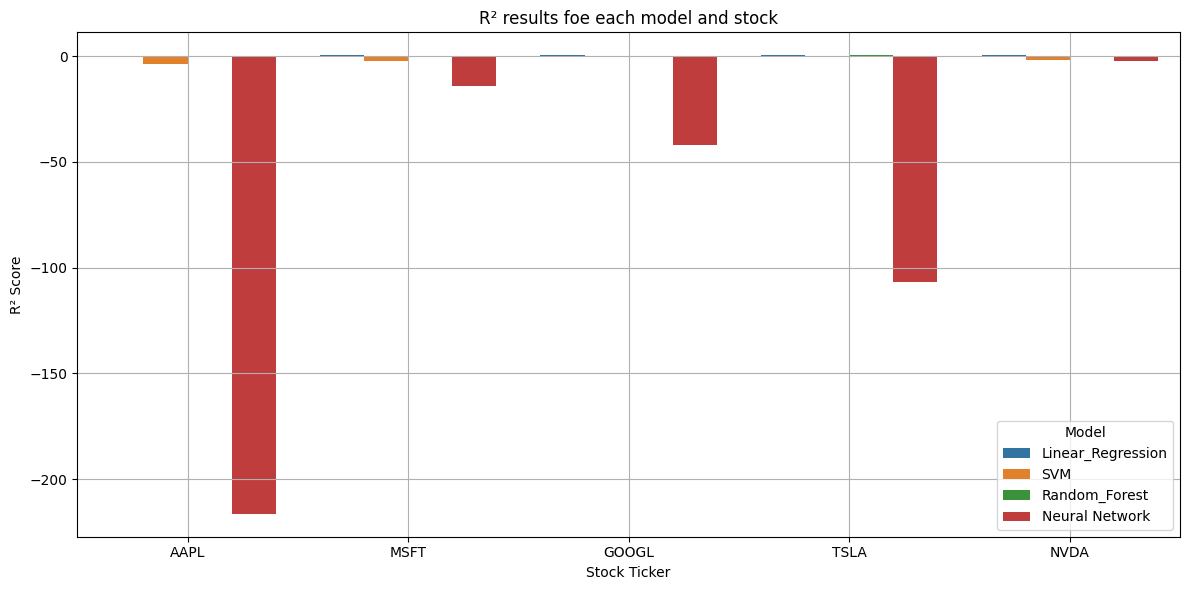

In [9]:
### plot for each ticker
# Create a summary DataFrame for visualization
summary = []

for ticker, model_results in results.items():
    for model, metrics in model_results.items():
        summary.append({
            'Ticker': ticker,
            'Model': model,
            'MSE': metrics['MSE'],
            'MAE': metrics['MAE'],
            'R2': metrics['R2']
        })

df_summary = pd.DataFrame(summary)

# Plot R² scores
plt.figure(figsize=(12, 6))
sns.barplot(data=df_summary, x='Ticker', y='R2', hue='Model')
plt.title("R² results foe each model and stock")
plt.ylabel("R² Score")
plt.xlabel("Stock Ticker")
plt.legend(title='Model')
plt.grid(True)
plt.tight_layout()
plt.show()

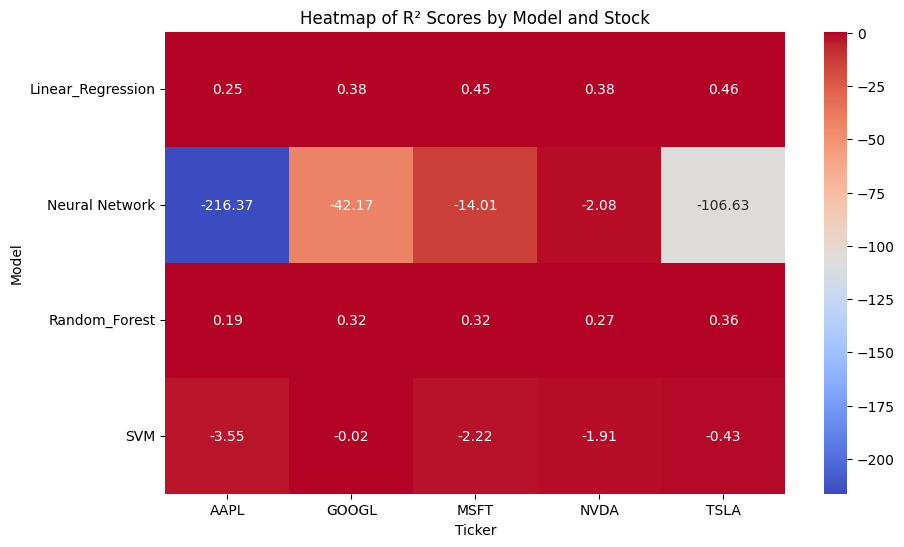

In [10]:
### 2. plot healtmap of r2
pivot_r2 = df_summary.pivot(index='Model', columns='Ticker', values='R2')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_r2, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Heatmap of R² Scores by Model and Stock")
plt.show()